Useful command to copy files from google drive to colab's local storage. Then, for example, you could copy them to your drive using the same command but different args. This is what's needed to do a deep copy of shared folders.

In [ ]:
# !rsync -ah --progress -r drive/MyDrive/Universita/MLDL/BiseNetv1/checkpoint_101_adversarial_both_augmentations/ checkpoint_101_adversarial_both_augmentations

# Setup

## Mount Drive

Mount Google Drive. This will create a new folder, called `My Drive` under `/content/drive/`. It is a FUSE-like filesystem mounted over the network, so the average IO performance is quite slow.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Move into the `BiseNetv1` directory, so that we are in the correct directory for python imports

In [2]:
%cd /content/drive/MyDrive/Universita/MLDL/BiseNetv1/

/content/drive/MyDrive/Universita/MLDL/BiseNetv1


In [3]:
%pwd

'/content/drive/MyDrive/Universita/MLDL/BiseNetv1'

Use autoreload extension so that when we change an imported module, it will get autoreloaded.

In [4]:
%load_ext autoreload
%autoreload 2

## Download

Download `CamVid` and `IDDA` datasets from a Google Cloud Storage bucket. Previously we downloaded them from Google Drive but there is (rightly so) a quite small download quota.

Files are downloaded to the local disk which has much faster IO than the mounted drive.

In [5]:
%%time
%cd /content
%pwd
!gsutil cp gs://recsys-2021-bucket/CamVid.zip /content/CamVid.zip
!gsutil cp gs://recsys-2021-bucket/IDDA.zip /content/IDDA.zip
!unzip -q CamVid.zip
!unzip -q IDDA.zip
!cp /content/drive/MyDrive/Universita/MLDL/classes_info.json /content/IDDA/classes_info.json
%cd /content/drive/MyDrive/Universita/MLDL/BiseNetv1/

/content
Copying gs://recsys-2021-bucket/CamVid.zip...
| [1 files][579.3 MiB/579.3 MiB]   62.1 MiB/s                                   
Operation completed over 1 objects/579.3 MiB.                                    
Copying gs://recsys-2021-bucket/IDDA.zip...
/ [1 files][  4.9 GiB/  4.9 GiB]   29.1 MiB/s                                   
Operation completed over 1 objects/4.9 GiB.                                      
/content/drive/MyDrive/Universita/MLDL/BiseNetv1
CPU times: user 1.15 s, sys: 210 ms, total: 1.36 s
Wall time: 2min 45s


# Validation

## Check GPU RAM

In [11]:
!nvidia-smi

Tue Jun 29 15:54:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Setup

In [12]:
import torch

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_theme()
%config InlineBackend.figure_format = 'retina'
from utils import reverse_one_hot, colour_code_segmentation
from torchvision import transforms as T

mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)
unnormalize = T.Normalize((-mean/std).tolist(), (1.0 / std).tolist())

In [13]:
!pip3 install tensorboardX

     |████████████████████████████████| 133kB 4.1MB/s 


In [14]:
from dataclasses import dataclass
@dataclass
class MyArgs:
  num_classes: int
  use_gpu: bool
  loss: str
from train import val

## Load generator checkpoint and datasets

Create BiSeNet and put it on the GPU.
Load the weights of the network we want to train.
Put the generator in `eval` mode, this is needed for e.g. batch normalization layers.

In [15]:
from model.build_BiSeNet import BiSeNet
NUM_CLASSES = 12
CONTEXT_PATH = 'resnet101'
generator = BiSeNet(NUM_CLASSES, CONTEXT_PATH).cuda()

In [16]:
!pwd

/content/drive/My Drive/Universita/MLDL/BiseNetv1


In [17]:
generator.load_state_dict(torch.load('/content/drive/MyDrive/Universita/MLDL/BiseNetv1/checkpointBeta01_T3/0.01_50_Generator.pth'))
generator.eval()
None

Now load both source and target dataset, respectively `IDDA` and `CamVid`.
Both datasets are loaded in `validation` mode, but the data which is loaded is actually the __training__ data, so be careful.

In [18]:
from torch.utils.data import DataLoader

from dataset.IDDA import IDDA
from dataset.CamVid import CamVid


CROP_HEIGHT = 720
CROP_WIDTH = 960

NUM_WORKERS = 0

CAMVID_PATH = ['/content/CamVid/train/', '/content/CamVid/val/']
CAMVID_TEST_PATH = ['/content/CamVid/test/']
CAMVID_LABEL_PATH = ['/content/CamVid/train_labels/', '/content/CamVid/val_labels/']
CAMVID_TEST_LABEL_PATH = ['/content/CamVid/test_labels/']
CSV_CAMVID_PATH = '/content/CamVid/class_dict.csv'

IDDA_PATH = '/content/IDDA/rgb/'
IDDA_LABEL_PATH = '/content/IDDA/labels'
JSON_IDDA_PATH = '/content/IDDA/classes_info.json'

BATCH_SIZE_CAMVID = 2
BATCH_SIZE_IDDA = 2

LOSS = 'dice'

source_dataset = IDDA(
    image_path=IDDA_PATH,
    label_path=IDDA_LABEL_PATH,
    classes_info_path=JSON_IDDA_PATH,
    scale=(CROP_HEIGHT, CROP_WIDTH),
    loss=LOSS,
    mode='val'
)
source_dataloader = DataLoader(
  source_dataset,
  batch_size=1,
  shuffle=True,
  num_workers=NUM_WORKERS,
  drop_last=True,
  pin_memory=True
)
target_dataset = CamVid(
  image_path=CAMVID_PATH,
  label_path= CAMVID_LABEL_PATH,csv_path= CSV_CAMVID_PATH,
  scale=(CROP_HEIGHT, CROP_WIDTH),
  loss=LOSS,
  mode='val'
)
target_dataloader = DataLoader(
  target_dataset,
  batch_size=1,
  shuffle=True,
  num_workers=NUM_WORKERS,
  drop_last=True,
  pin_memory=True
)
source_dataloader_iter = iter(source_dataloader)
target_dataloader_iter = iter(target_dataloader)

So this is the performance on the **training** target dataset.

In [19]:
%%time
# val(MyArgs(NUM_CLASSES, True, 'dice'), generator, target_dataloader_iter)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


Now we load `CamVid` test data in `validation` mode. This is what we actually use to calculate validation performance.

In [20]:
%%time
target_dataset_test = CamVid(
  image_path=CAMVID_TEST_PATH,
  label_path= CAMVID_TEST_LABEL_PATH,csv_path= CSV_CAMVID_PATH,
  scale=(CROP_HEIGHT, CROP_WIDTH),
  loss=LOSS,
  mode='val'
)
target_dataloader_test = DataLoader(
  target_dataset_test,
  batch_size=1,
  shuffle=True,
  num_workers=NUM_WORKERS,
  drop_last=True,
  pin_memory=True
)
target_dataloader_test_iter = iter(target_dataloader_test)
val(MyArgs(NUM_CLASSES, True, 'dice'), generator, target_dataloader_test_iter, CSV_CAMVID_PATH)

start val!!
precision per pixel for test: 0.718
mIoU for validation: 0.328
mIoU for each class:
Bicyclist:0.0,
Building:0.648269051457258,
Car:0.6708883058919112,
Column_Pole:0.027927318031090217,
Fence:0.027653926793061386,
Pedestrian:0.0004831844003771266,
Road:0.6833199214570265,
Sidewalk:0.2494362235743854,
SignSymbol:0.026650915920311904,
Sky:0.788303596530285,
Tree:0.48283256909411554,

CPU times: user 4min 1s, sys: 970 ms, total: 4min 2s
Wall time: 3min 49s


## Create validation curve

In [ ]:
results = []
for epoch in range(5, 51, 5):
  target_dataloader_test_iter = iter(target_dataloader_test)
  generator.load_state_dict(torch.load(f'/content/drive/MyDrive/Universita/MLDL/BiseNetv1/checkpoint_101_adversarial_both_augmentation_epoch_len_IDDA/{epoch}_Generator.pth'))
  generator.eval()
  validation_result = val(MyArgs(NUM_CLASSES, True, 'dice'), generator, target_dataloader_test_iter)
  print(epoch, validation_result)
  results.append((epoch, validation_result))
results

start val!
precision per pixel for test: 0.669
mIoU for validation: 0.293
5 (0.6686356439258465, 0.29301514409492424)
start val!
precision per pixel for test: 0.701
mIoU for validation: 0.331
10 (0.7006315569861707, 0.33090263495729305)
start val!
precision per pixel for test: 0.695
mIoU for validation: 0.347
15 (0.6953772874940389, 0.346956391683519)
start val!
precision per pixel for test: 0.678
mIoU for validation: 0.335
20 (0.6780706813304721, 0.33485004480142994)
start val!
precision per pixel for test: 0.670
mIoU for validation: 0.332
25 (0.6696029111528374, 0.3324233206554515)
start val!
precision per pixel for test: 0.663
mIoU for validation: 0.325
30 (0.6634729735435543, 0.3249984991515137)
start val!
precision per pixel for test: 0.661
mIoU for validation: 0.326
35 (0.6612371468168812, 0.32641483149985534)
start val!
precision per pixel for test: 0.635
mIoU for validation: 0.306
40 (0.6349022723434272, 0.3057748601213181)
start val!
precision per pixel for test: 0.611
mIoU fo

[(5, (0.6686356439258465, 0.29301514409492424)),
 (10, (0.7006315569861707, 0.33090263495729305)),
 (15, (0.6953772874940389, 0.346956391683519)),
 (20, (0.6780706813304721, 0.33485004480142994)),
 (25, (0.6696029111528374, 0.3324233206554515)),
 (30, (0.6634729735435543, 0.3249984991515137)),
 (35, (0.6612371468168812, 0.32641483149985534)),
 (40, (0.6349022723434272, 0.3057748601213181)),
 (45, (0.6106800575723256, 0.2883965959833228)),
 (50, (0.6106359779844223, 0.28546795898578126))]

In [ ]:
([x[0] for x in results], [x[1] for x in results])

([5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
 [(0.6686356439258465, 0.29301514409492424),
  (0.7006315569861707, 0.33090263495729305),
  (0.6953772874940389, 0.346956391683519),
  (0.6780706813304721, 0.33485004480142994),
  (0.6696029111528374, 0.3324233206554515),
  (0.6634729735435543, 0.3249984991515137),
  (0.6612371468168812, 0.32641483149985534),
  (0.6349022723434272, 0.3057748601213181),
  (0.6106800575723256, 0.2883965959833228),
  (0.6106359779844223, 0.28546795898578126)])

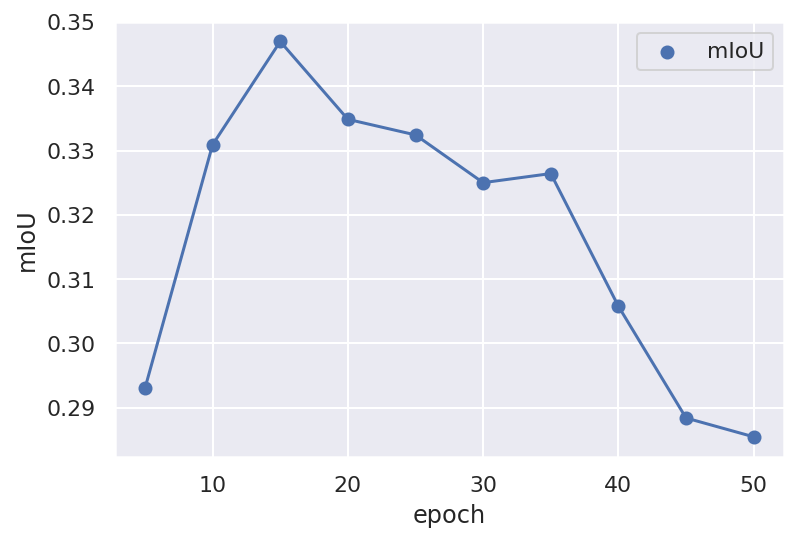

In [ ]:
plt.scatter([x[0] for x in results], [x[1][1] for x in results], label='mIoU')
plt.plot([x[0] for x in results], [x[1][1] for x in results])
# plt.scatter([x[0] for x in results], [x[1][0] for x in results])
# plt.plot([x[0] for x in results], [x[1][0] for x in results])
plt.xlabel('epoch')
plt.ylabel('mIoU')
plt.legend()

## Visually compare target and source predictions and their targets

torch.Size([1, 3, 1080, 1920]) torch.Size([1, 12, 1080, 1920]) torch.Size([1, 3, 720, 960]) torch.Size([1, 12, 720, 960])


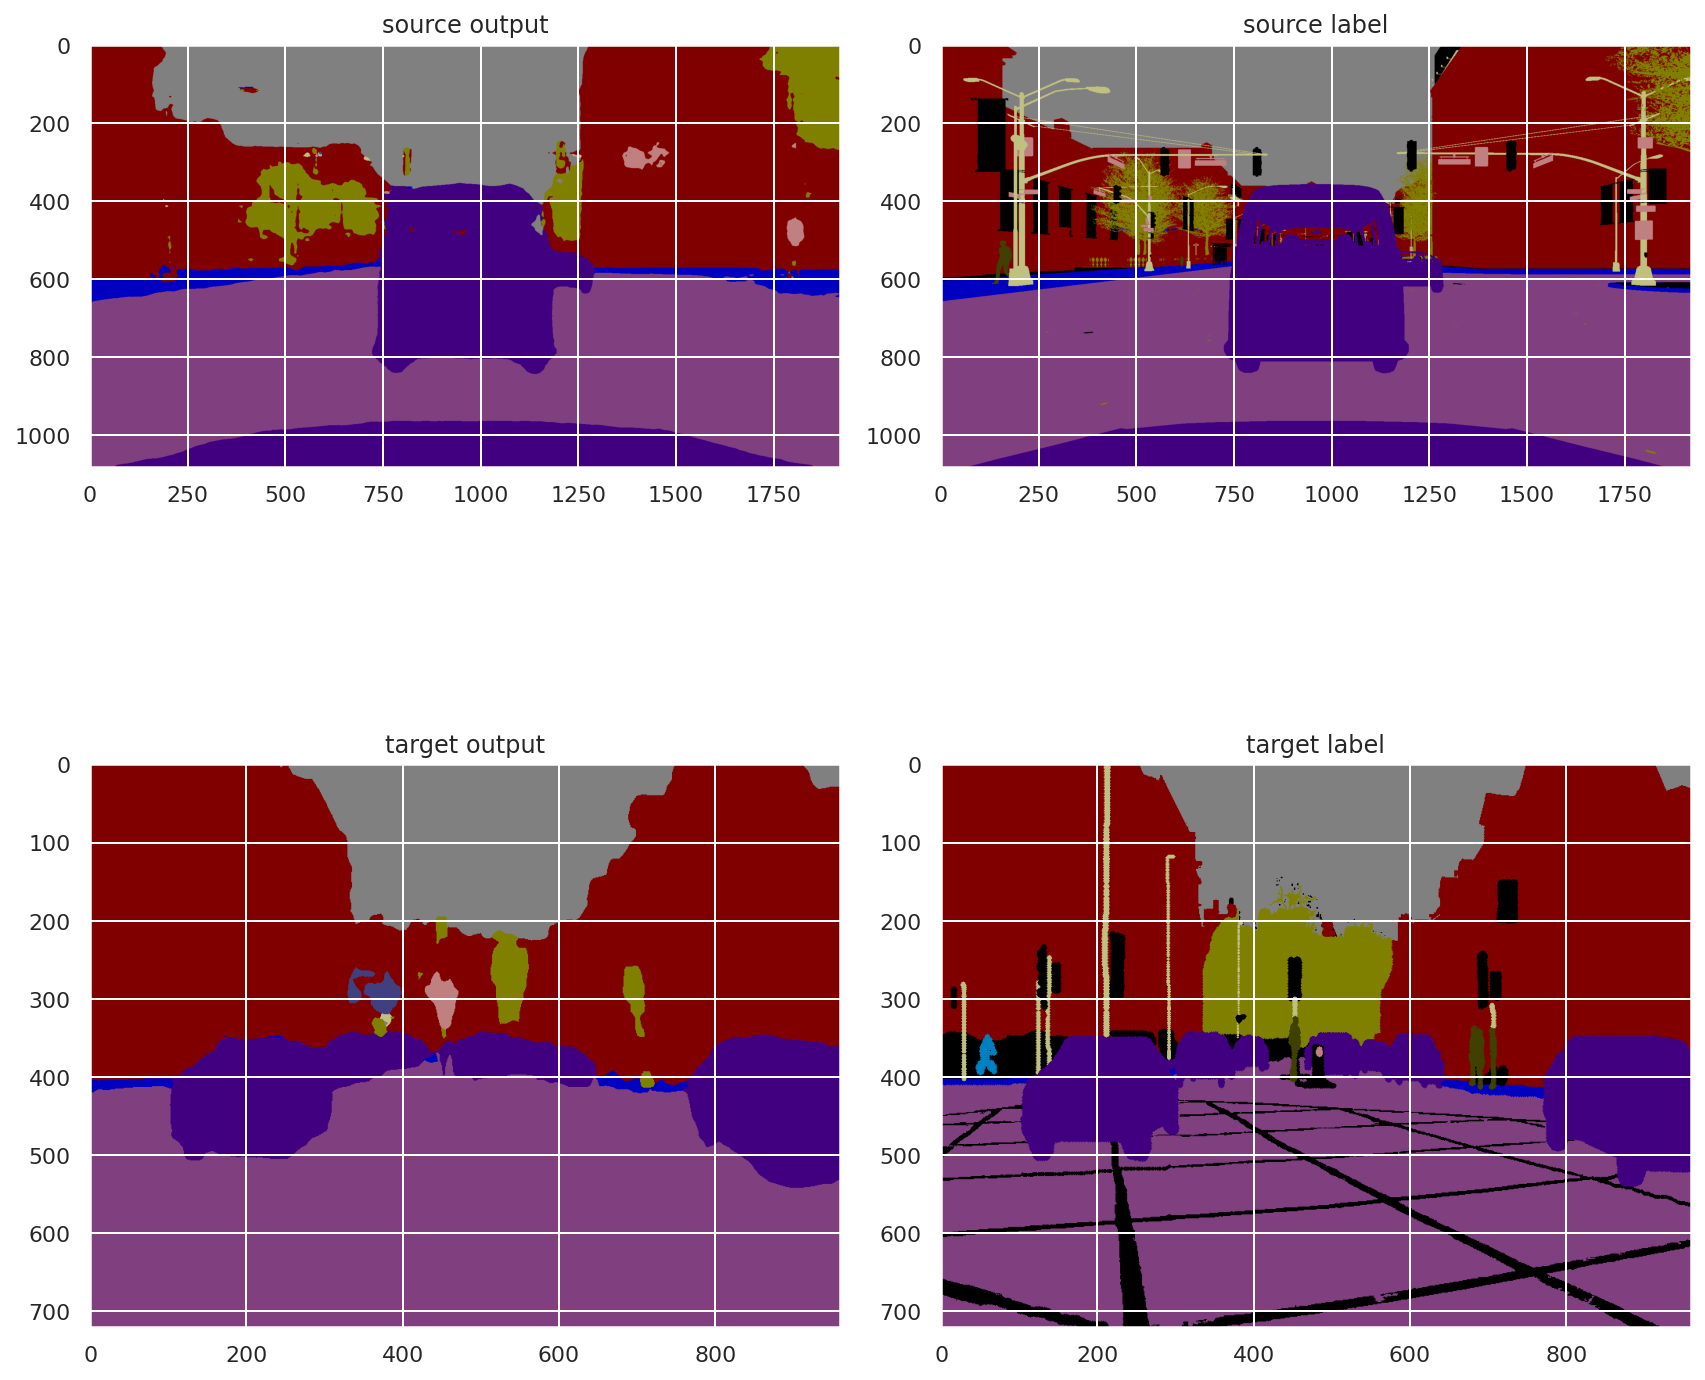

In [ ]:
I_s, Y_s = next(source_dataloader_iter)
I_t, Y_t = next(target_dataloader_iter)
print(I_s.shape, Y_s.shape, I_t.shape, Y_t.shape)
with torch.no_grad():
  P_s = generator(I_s.cuda())
P_s.shape
with torch.no_grad():
  P_t = generator(I_t.cuda())
P_t.shape
MINIBATCH_INDEX = 0
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
ax1.set_title("source output")
ax1.imshow(colour_code_segmentation(reverse_one_hot(P_s[MINIBATCH_INDEX, :, :, :]).cpu().numpy(), target_dataset.label_info))
ax2.set_title("source label")
ax2.imshow(colour_code_segmentation(reverse_one_hot(Y_s[MINIBATCH_INDEX, :, :, :]).cpu().numpy(), target_dataset.label_info))
ax3.set_title("target output")
ax3.imshow(colour_code_segmentation(reverse_one_hot(P_t[MINIBATCH_INDEX, :, :, :]).cpu().numpy(), target_dataset.label_info))
ax4.set_title("target label")
ax4.imshow(colour_code_segmentation(reverse_one_hot(Y_t[MINIBATCH_INDEX, :, :, :]).cpu().numpy(), target_dataset.label_info))
fig.tight_layout()

# Weights and Biases experiment tracking

Just testing it, it's not necessary to run the scripts. If you need to run the
python script anyway just remove all `wandb` references and it will work.

In [6]:
!rsync -ah --progress -r /content/drive/MyDrive/Universita/MLDL/T2_CamVid_train_pseudolabels/ /content/T2_CamVid_train_pseudolabels

sending incremental file list
created directory /content/T2_CamVid_train_pseudolabels
./
0001TP_006690.png
         13.18K 100%    0.00kB/s    0:00:00 (xfr#1, to-chk=467/469)
0001TP_006720.png
         13.56K 100%   20.09kB/s    0:00:00 (xfr#2, to-chk=466/469)
0001TP_006750.png
         12.38K 100%    0.00kB/s    0:00:00 (xfr#3, to-chk=465/469)
0001TP_006780.png
         12.61K 100%   18.40kB/s    0:00:00 (xfr#4, to-chk=464/469)
0001TP_006810.png
         13.57K 100%   10.33kB/s    0:00:01 (xfr#5, to-chk=463/469)
0001TP_006840.png
         14.55K 100%    0.00kB/s    0:00:00 (xfr#6, to-chk=462/469)
0001TP_006870.png
         14.54K 100%   21.95kB/s    0:00:00 (xfr#7, to-chk=461/469)
0001TP_006900.png
         16.17K 100%   12.28kB/s    0:00:01 (xfr#8, to-chk=460/469)
0001TP_006930.png
         16.18K 100%    0.00kB/s    0:00:00 (xfr#9, to-chk=459/469)
0001TP_006960.png
         16.76K 100%   26.49kB/s    0:00:00 (xfr#10, to-chk=458/469)
0001TP_006990.png
         16.22K 100%   12.89kB/s

In [7]:
!pip install wandb

     |████████████████████████████████| 1.8MB 4.1MB/s 
     |████████████████████████████████| 102kB 14.8MB/s 
     |████████████████████████████████| 133kB 47.2MB/s 
     |████████████████████████████████| 174kB 55.5MB/s 
     |████████████████████████████████| 71kB 12.4MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6502 sha256=6bda7250ce13c6e0c9b4a770011eeb6dc4fe8f1a63bf21fbafba09bcc8834b9b
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8807 sha256=d4c7615de638ef539a5b0ab896ee8f97511feccd5cfa37cfbc5e17d527601053
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools


In [8]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Running


In [9]:
!python SStrain_FDA_adversarial_01.py

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100% 44.7M/44.7M [00:00<00:00, 135MB/s] 
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100% 171M/171M [00:02<00:00, 72.0MB/s]
wandb: Currently logged in as: mrandri19 (use `wandb login --relogin` to force relogin)
2021-06-29 12:12:04.959758: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
wandb: Tracking run with wandb version 0.10.32
wandb: Syncing run polar-tree-8
wandb: ⭐️ View project at https://wandb.ai/mrandri19/BiseNetv1
wandb: 🚀 View run at https://wandb.ai/mrandri19/BiseNetv1/runs/13y2rnbc
wandb: Run data is saved locally in /content/drive/My Drive/Universita/MLDL/BiseNetv1/wandb/run-20210629_121158-13y2rnbc
wandb: Run `wandb offline` to turn off syncing.

begin epoch 31
100% 234/234 [10:56

dwadawdawdwa
**OHHH** look at *this* $\frac{1}{2}$